# SGD_pagerank

### **Preprocessing for PageRank on Single Cell Data**

### **1. Graph Representation**

Represent the graph by its adjacency matrix \( A \), where \( A_{ij} \) represents the weight of the edge from node \( i \) to node \( j \). If there's no edge between \( i \) and \( j \), \( A_{ij} = 0 \).

### **2. Degree Calculation**

The degree \( D_i \) of a node \( i \) is the sum of the weights of its edges:

$$
D_i = \sum_{j} A_{ij}
$$

### **3. Graph Normalization**

Given the adjacency matrix \( A \) derived from single cell data, it's crucial to normalize this matrix to ensure that the computation is not unduly influenced by nodes (cells) with higher degrees. Two primary normalization techniques can be applied:

#### **A. Normalized Adjacency Matrix**

For each node \( i \), compute the inverse square root of its degree:

$$
S_i = \frac{1}{\sqrt{D_i}}
$$

Modify the adjacency matrix \( A \) using these values:

$$
M_1 = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$

Where:
- \( A \) is the adjacency matrix.
- \( D \) is the diagonal matrix with node degrees.

**Rationale**:
- This normalization emphasizes nodes that have meaningful connections, i.e., nodes that are connected to other nodes with high degrees.
- Suitable for situations where you want to capture the core structure of the graph, emphasizing stronger connections.

#### **B. Modified Normalized Laplacian**

$$
L_{\text{norm}} = I + D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$

Where:
- \( I \) is the identity matrix.

**Rationale**:
- The normalized Laplacian captures the difference between a node's isolated state and its actual connections.
- Suitable for spectral clustering and other methods that require understanding the difference in connectivity patterns.

### **4. PageRank Computation**

Once the matrix is normalized, we can compute the PageRank. Two main computation techniques can be applied:

#### **A. Traditional PageRank**

The PageRank vector \( v \) is iteratively updated using:

$$
v_{\text{new}} = d \times M v_{\text{old}} + \frac{(1 - d)}{N}
$$

Where:
- \( d \) is the damping factor.
- \( N \) is the total number of nodes.
- \( M \) can be either \( M_1 \) or \( L_{\text{norm}} \), depending on the chosen normalization.

**Rationale**:
- Direct and comprehensive: Every iteration updates using the entire graph.
- Suitable when computational resources are not a constraint and when we want a deterministic outcome.

#### **B. SGD-PageRank**

The iterative update equation for a mini-batch is:

$$
v_{\text{mini\_batch}} = d \times (\text{learning\_rate} \times M_{\text{mini\_batch}} v) + \frac{(1 - d)}{N}
$$

**Rationale**:
- Stochastic Gradient Descent (SGD) approach is more scalable and can handle large graphs efficiently by only using a subset of the graph in each iteration.
- Suitable for very large graphs where traditional PageRank may be computationally intensive.
- Provides a level of randomness which might help escape local minima.
- Two sampling methods are proposed: `probability_based` (where nodes less visited have a higher chance of being selected) and `cyclic` (nodes are visited in a cycle).

### **5. Convergence**

Convergence in the SGD approach is determined by monitoring the L2 norm between the current and previous PageRank vectors. A smoothed L2 norm is also calculated to detect 'dips' in the convergence curve, which can signal phases where the model begins to learn the graph's structure.

---

### **Summary**

The proposed method provides a comprehensive framework for preprocessing single cell data and computing PageRank scores. By offering options at each step, it allows users to tailor the approach to their specific dataset and computational constraints. The method capitalizes on the strengths of both traditional and SGD-based PageRank algorithms, ensuring scalability without compromising on the accuracy of the derived rankings.

- Ergodan theory of markov chains -- we will always approach a stationary state of a transition matrix if we keep multiplyin against a set of random integers

# Proofs Laplacian SGD pagerank

In [1]:
import scanpy as sc

In [2]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad')

In [3]:
adjacency_matrix = adata.obsp['connectivities']

PG on norm adj


/tmp/ipykernel_3322/638447897.py:157: RuntimeWarning: invalid value encountered in subtract
  l2_norm = np.linalg.norm(v - last_v)


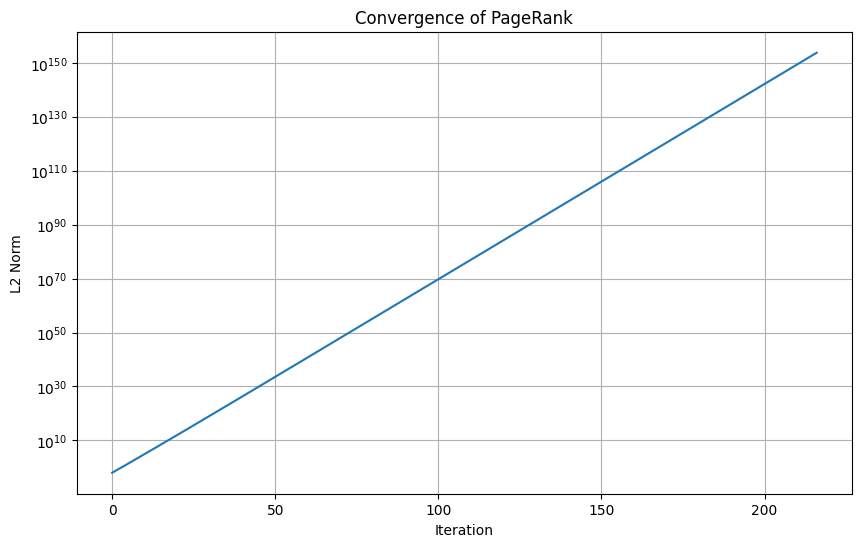

PG on norm inv sqrt degree
Converged at iteration 51


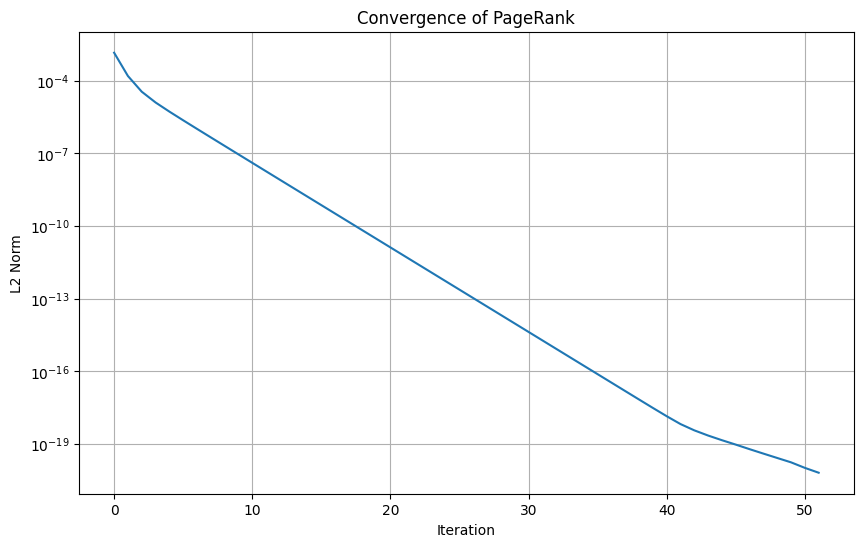

PG on norm laplacian
Converged at iteration 736


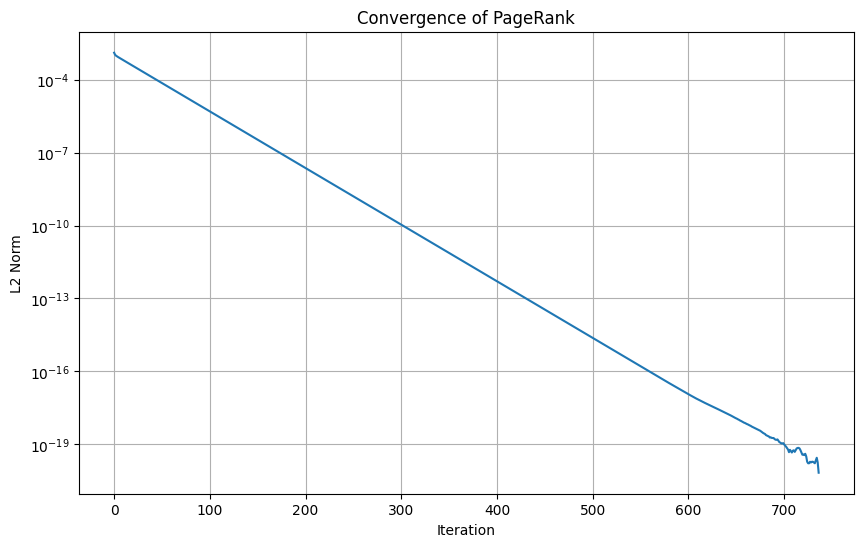

StopIteration: 

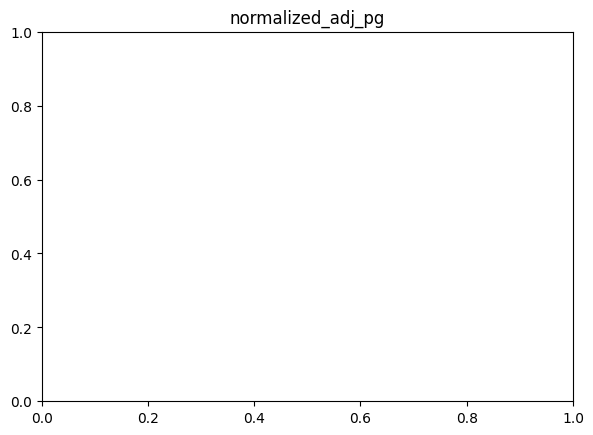

In [67]:
import numpy as np
import scipy.sparse
import networkx as nx
import matplotlib.pyplot as plt
from math import e


# Generate the adjacency matrix
#adjacency_matrix = #generate_simulated_adjacency_matrix()
neighborhood_matrix = adjacency_matrix
# Visualize the graph
# G = nx.from_numpy_array(adjacency_matrix)
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=12, width=1)
# plt.title("Generated Graph")
# plt.show()



#compute normalised laplacian:
# This is a modified laplacian, instead of subtracting from identity matrix, we add it
def compute_normalized_laplacian(neighborhood_matrix):
    """
    Compute the normalized Laplacian matrix for a given neighborhood (adjacency) matrix.
    
    Parameters:
    - neighborhood_matrix (numpy.ndarray): The adjacency matrix of the graph.
    
    Returns:
    - numpy.ndarray: The normalized Laplacian matrix.
    
    The addition of ones on the diagonal in the normalized Laplacian provides a reference point, 
    emphasizing the difference between a node's connectivity and a hypothetical isolated state.
    - isolated states are given as the diagonal ones in the identity matrix.
    - A negative value closer to zero represents less connected values
    - A negative value further away from zero represtns more connected values
    - This essentially captures the relative lack of connectivity in relation to their neighbors 
    """
    
    # Compute degrees for each node
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1  # Adding 1 to avoid division by zero
    
    # Calculate the inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    
    
    # Create the diagonal matrix of inverse square root degrees
    #inv_sqrt_deg_matrix = np.diag(inv_sqrt_degrees)
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    
    # Compute the normalized adjacency matrix
    normalized_adjacency = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    
    # Compute the normalized Laplacian matrix
    normalized_laplacian = scipy.sparse.eye(neighborhood_matrix.shape[0]) + normalized_adjacency
    
    return normalized_laplacian

# Example usage:
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
normalized_laplacian = np.array(compute_normalized_laplacian(neighborhood_matrix))
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
normalized_laplacian = (compute_normalized_laplacian(neighborhood_matrix))
#normalized_laplacian = normalized_laplacian+(1*e**-6)

# row_sums = normalized_laplacian.sum(axis=1)
# row_sums_inv = 1.0 / row_sums
# row_sums_inv[row_sums == 0] = 0  # handle divide-by-zero cases
# diagonal_matrix = sp.diags(row_sums_inv.A1)  # Convert matrix to 1D array with .A1
# normalized_laplacian = diagonal_matrix.dot(normalized_laplacian)

# This is a invrt sqrt_norm mat
def compute_inv_sqrt_norm(neighborhood_matrix):
    """
    Compute the inverted normalised square root matrix for a given neighborhood (adjacency) matrix.
    
    Parameters:
    - neighborhood_matrix (numpy.ndarray): The adjacency matrix of the graph.
    
    Returns:
    - numpy.ndarray: The normalized Laplacian matrix.
    
    The addition of ones on the diagonal in the normalized Laplacian provides a reference point, 
    emphasizing the difference between a node's connectivity and a hypothetical isolated state.
    - isolated states are given as the diagonal ones in the identity matrix.
    - A negative value closer to zero represents less connected values
    - A negative value further away from zero represtns more connected values
    - This essentially captures the relative lack of connectivity in relation to their neighbors 
    """
    
    # Compute degrees for each node
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1  # Adding 1 to avoid division by zero
    
    # Calculate the inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    
    
    # Create the diagonal matrix of inverse square root degrees
    #inv_sqrt_deg_matrix = np.diag(inv_sqrt_degrees)
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    
    # Compute the normalized adjacency matrix
    normalized_adjacency = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    
    return normalized_adjacency

# Example usage:
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
normalized_inv = compute_inv_sqrt_norm(neighborhood_matrix)
#normalized_inv = normalized_inv+(1*e**-6)
#normalized_inv = normalized_inv/normalized_inv.sum(axis=1)[:,None]
# normalized_inv = normalized_inv/normalized_inv.sum(axis=0)
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
#normalized_laplacian = normalized_laplacian+(1*e**-6)

# row_sums = normalized_inv.sum(axis=1)
# row_sums_inv = 1.0 / row_sums
# row_sums_inv[row_sums == 0] = 0  # handle divide-by-zero cases
# diagonal_matrix = sp.diags(row_sums_inv.A1)  # Convert matrix to 1D array with .A1
# normalized_inv = diagonal_matrix.dot(normalized_inv)


#normalized_adj = neighborhood_matrix+(1*e**-6)
#normalized_adj = normalized_adj/normalized_adj.sum(axis=1)[:,None]
normalized_adj = neighborhood_matrix

# row_sums = normalized_adj.sum(axis=1)
# row_sums_inv = 1.0 / row_sums
# row_sums_inv[row_sums == 0] = 0  # handle divide-by-zero cases
# diagonal_matrix = sp.diags(row_sums_inv.A1)  # Convert matrix to 1D array with .A1
# normalized_adj = diagonal_matrix.dot(normalized_adj)


def pagerank(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    Calculate the PageRank of each node in a graph.
    
    Parameters:
    M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    num_iterations (int): The maximum number of iterations to perform.
    d (float): The damping factor.
    tolerance (float): The tolerance for convergence.
    
    Returns:
    numpy.ndarray: The PageRank score for each node in the graph.
    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    damping = ((1 - d) / N) * np.ones((N, 1))
    last_v = np.ones((N, 1)) * np.inf
    l2_dic = {}
    for _ in range(num_iterations):
        last_v = v
        v = d * M @ v + damping
        l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(_))
            break
            
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()))
    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.grid(True)
    plt.show()

    return v, l2_dic

def plot_graph_with_scores(G, scores, title):
    """
    Plot the graph with nodes colored by the given scores.
    
    Parameters:
    - G (networkx.Graph): The graph.
    - scores (dictionary of numpy.ndarray): The scores for coloring nodes.
    - title (str): The title for the plot.
    """
    
    
    pos = nx.spring_layout(G)
    for score in scores.keys():
        print(score)
        scores_ = scores[score]
        title_ = str(title) + str(score) 
        plt.figure(figsize=(12, 8))
        nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=scores_, cmap=plt.cm.coolwarm)
        nx.draw_networkx_edges(G, pos, width=1)
        nx.draw_networkx_labels(G, pos, font_size=10)
        plt.title(title_)
        plt.colorbar(nodes)
        plt.axis('off')
        plt.show()
    return pos
        

print('PG on norm adj')
normalized_adj_pg,l2_dic  = pagerank(normalized_adj, 1000, d=0.5, tolerance=1e-20)
print('PG on norm inv sqrt degree')
normalized_inv_pg,l2_dic = pagerank(normalized_inv, 1000, d=0.5, tolerance=1e-20)
print('PG on norm laplacian')
normalized_laplacian_pg,l2_dic = pagerank(normalized_laplacian, 1000, d=0.5, tolerance=1e-20)

scores = {
'normalized_adj_pg':normalized_adj_pg,
'normalized_inv_pg':normalized_inv_pg,
'normalized_laplacian_pg':normalized_laplacian_pg,
}

# Plot the graph colored by PageRank scores for the normalized adjacency matrix
#pos = plot_graph_with_scores(G, scores, "PageRank -")
for key in scores.keys():
    adata.obs[key] = scores[key]
sc.pl.umap(adata,color =  scores.keys())

In [ ]:
for key in scores.keys():
    adata.obs[key] = (scores[key])
    adata.obs[key] =((adata.obs[key] - min(adata.obs[key])) / max(adata.obs[key]))*1*10**16
sc.pl.umap(adata,color =  scores.keys())

In [ ]:
keep = adata.obs[key].nlargest(3000).index
adata_tmp = adata[adata.obs.index.isin(keep)]
sc.pl.umap(adata_tmp,color =  scores.keys())
sc.pl.umap(adata_tmp,color =  'cell.labels')
len(adata_tmp.obs['cell.labels'].unique())

In [ ]:
len(adata_tmp.obs['cell.labels'].unique())

In [ ]:
len(adata.obs['cell.labels'].unique())

In [16]:
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
normalized_laplacian = (compute_normalized_laplacian(neighborhood_matrix))
#normalized_laplacian = normalized_laplacian+(1*e**-6)
row_sums = normalized_laplacian.sum(axis=1)
row_sums_inv = 1.0 / row_sums
row_sums_inv[row_sums == 0] = 0  # handle divide-by-zero cases

diagonal_matrix = sp.diags(row_sums_inv.A1)  # Convert matrix to 1D array with .A1
normalized_laplacian = diagonal_matrix.dot(normalized_laplacian)


In [17]:
normalized_laplacian

<169494x169494 sparse matrix of type '<class 'numpy.float64'>'
	with 5467782 stored elements in Compressed Sparse Row format>

In [146]:
# Compute degrees for each node
degrees_si = np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1  # Adding 1 to avoid division by zero
degrees_sj = np.array(neighborhood_matrix.sum(axis=0)).flatten() + 1  # Adding 1 to avoid division by zero

# Calculate the inverse square root of degrees
si_inv_sqrt_degrees = 1 / np.sqrt(degrees_si)
sj_inv_sqrt_degrees = 1 / np.sqrt(degrees_sj)

# Create the diagonal matrix of inverse square root degrees
#inv_sqrt_deg_matrix = np.diag(inv_sqrt_degrees)
si_inv_sqrt_deg_matrix = scipy.sparse.diags(si_inv_sqrt_degrees)
sj_inv_sqrt_deg_matrix = scipy.sparse.diags(sj_inv_sqrt_degrees)

# Compute the normalized adjacency matrix
normalized_adjacency = si_inv_sqrt_deg_matrix @ neighborhood_matrix @ sj_inv_sqrt_deg_matrix
normalized_adjacency = normalized_adjacency+(1*e**-6)
normalized_adjacency = normalized_adjacency/normalized_adjacency.sum(axis=1)[:,None]


##nm
normalized_adj = neighborhood_matrix+(1*e**-6)
normalized_adj = normalized_adj/normalized_adj.sum(axis=1)[:,None]

# Reconstruct KNN

In [147]:
adjacency_matrix

array([[0.        , 0.25808924, 0.5095926 , ..., 0.        , 0.        ,
        0.        ],
       [0.25808924, 0.        , 0.97164733, ..., 0.        , 0.        ,
        0.        ],
       [0.5095926 , 0.97164733, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

/tmp/ipykernel_1991/1039914869.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=normalized_laplacian_pg.min(), vmax=normalized_laplacian_pg.max())))


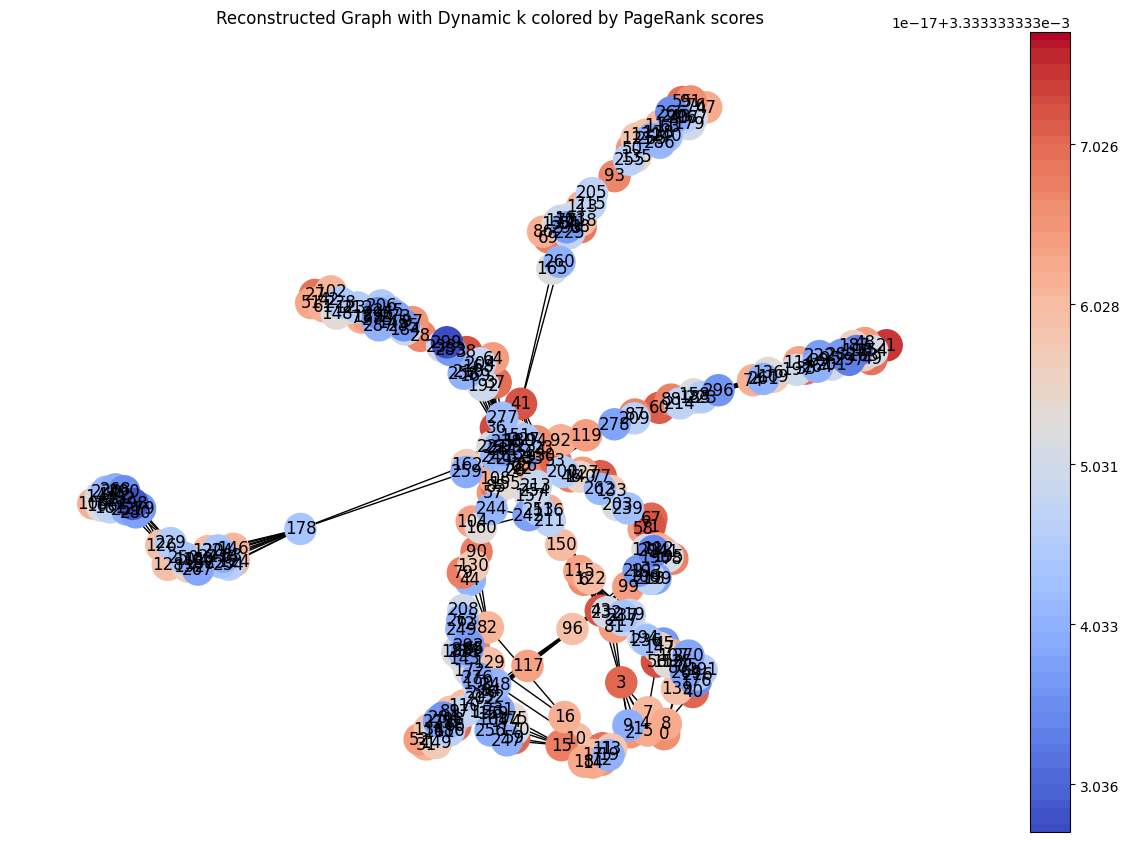

/tmp/ipykernel_1991/1039914869.py:100: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=normalized_laplacian_pg.min(), vmax=normalized_laplacian_pg.max())))


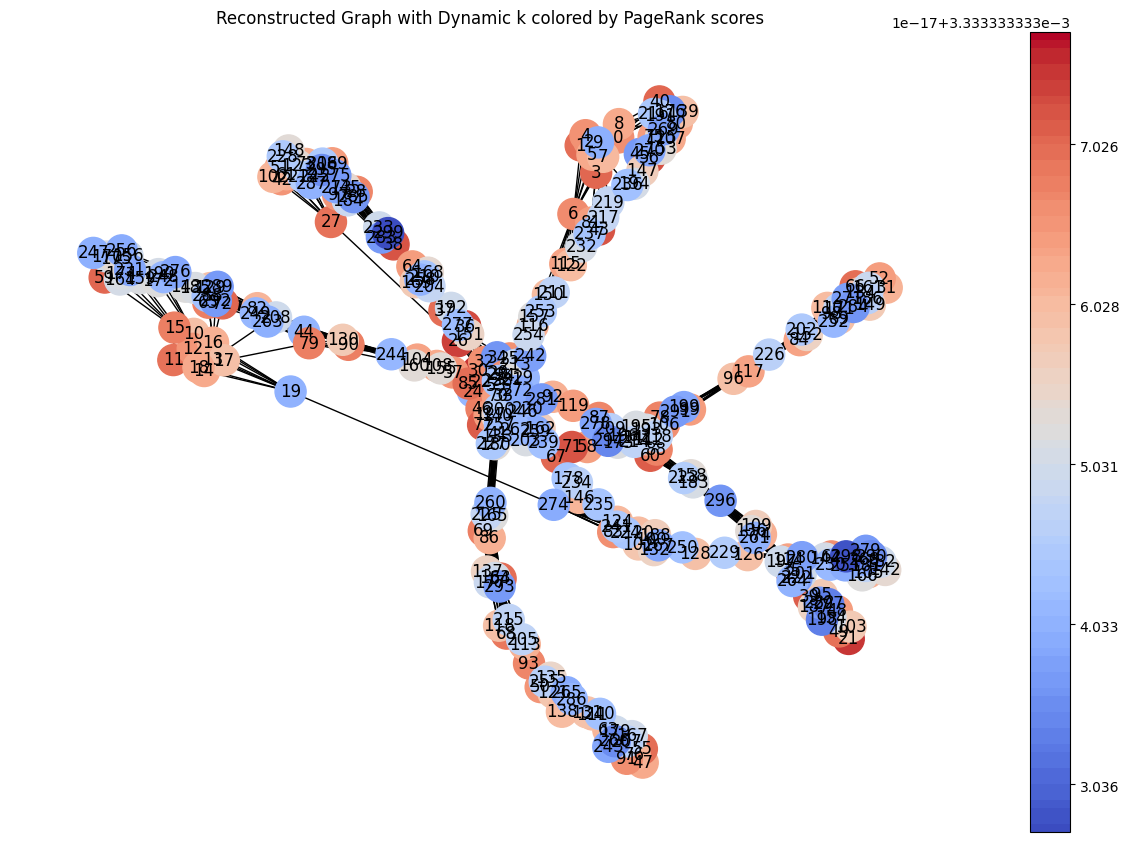

In [151]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
import umap
from pynndescent import NNDescent

def sigmoid(x):
    """
    Sigmoid function
    """
    return 1 / (1 + np.exp(-x))

def dynamic_k_sigmoid(rank, max_k, min_k, n_nodes):
    """
    Determine the dynamic k for a node based on its rank using a sigmoid function.
    """
    # Normalize rank
    normalized_rank = 2 * (rank / n_nodes) - 1  # scales rank to [-1, 1]
    
    # Get sigmoid weight
    weight = sigmoid(normalized_rank)
    
    # Scale to [min_k, max_k]
    return min_k + weight * (max_k - min_k)

def dynamic_k(rank, max_k, min_k, n_nodes):
    """
    Determine the dynamic k for a node based on its rank.
    Linearly scales between max_k and min_k based on rank.
    """
    return max_k - ((rank / n_nodes) * (max_k - min_k))


from scipy.sparse import csr_matrix, lil_matrix

def dynamic_knn(adjacency_matrix, pagerank_scores, max_k, min_k):
    """
    Construct the kNN graph using dynamic k values based on PageRank scores.
    
    Parameters:
    - adjacency_matrix (numpy.ndarray): The adjacency matrix of the graph.
    - pagerank_scores (numpy.ndarray): The PageRank scores for each node.
    - max_k (int): Maximum k value for nodes with highest PageRank.
    - min_k (int): Minimum k value for nodes with lowest PageRank.
    
    Returns:
    - scipy.sparse.csr_matrix: The reconstructed adjacency matrix with dynamic k values.
    """
    n_nodes = adjacency_matrix.shape[0]
    
    # Update the k_values determination in the dynamic_knn function
    ranks = np.argsort(pagerank_scores, axis=0)[::-1]
    k_values = [dynamic_k_sigmoid(rank, max_k, min_k, n_nodes) for rank in ranks]
    k_values = np.array(k_values, dtype=int).flatten()
    
    # Use UMAP's NNDescent for approximate nearest neighbor search
    index = NNDescent(adjacency_matrix)
    
    # Initialize a new adjacency matrix as a sparse LIL matrix
    new_adj_matrix = lil_matrix(adjacency_matrix.shape)
    
    # Get the k nearest neighbors for all nodes
    neighbors = index.query(adjacency_matrix, k=max_k)[0]

    # For each node, only keep the top k neighbors
    for i in range(n_nodes):
        new_adj_matrix[i, neighbors[i][:k_values[i]]] = 1
        # Convert the LIL matrix to CSR format for efficiency
    new_adj_matrix = new_adj_matrix.tocsr()
    
    return new_adj_matrix

# Call the function
dynamic_knn_adj_matrix = dynamic_knn(adjacency_matrix, normalized_laplacian_pg, max_k, min_k,)
dynamic_knn_adj_matrix = dynamic_knn_adj_matrix -  scipy.sparse.eye(dynamic_knn_adj_matrix.shape[0])

# Convert the CSR matrix to a dense numpy array for visualization
dynamic_knn_adj_array = dynamic_knn_adj_matrix.toarray()

# Visualize the reconstructed graph
G_dynamic_knn = nx.from_numpy_array(dynamic_knn_adj_array)
G_orig_knn = nx.from_numpy_array(adjacency_matrix)
# Visualize the reconstructed graph colored by PageRank scores
plt.figure(figsize=(12, 8))
if pos:
    pos = pos
else:
    pos = nx.spring_layout(G_dynamic_knn)

# Using the PageRank scores for coloring
nx.draw(G_dynamic_knn, pos, with_labels=True, node_size=500, node_color=normalized_laplacian_pg.flatten(), cmap=plt.cm.coolwarm, font_size=12, width=1)
plt.title("Reconstructed Graph with Dynamic k colored by PageRank scores")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=normalized_laplacian_pg.min(), vmax=normalized_laplacian_pg.max())))
plt.show()

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
# Using the PageRank scores for coloring
nx.draw(G_orig_knn, pos, with_labels=True, node_size=500, node_color=normalized_laplacian_pg.flatten(), cmap=plt.cm.coolwarm, font_size=12, width=1)
plt.title("Reconstructed Graph with Dynamic k colored by PageRank scores")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=normalized_laplacian_pg.min(), vmax=normalized_laplacian_pg.max())))
plt.show()

In [150]:
dynamic_knn_adj_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

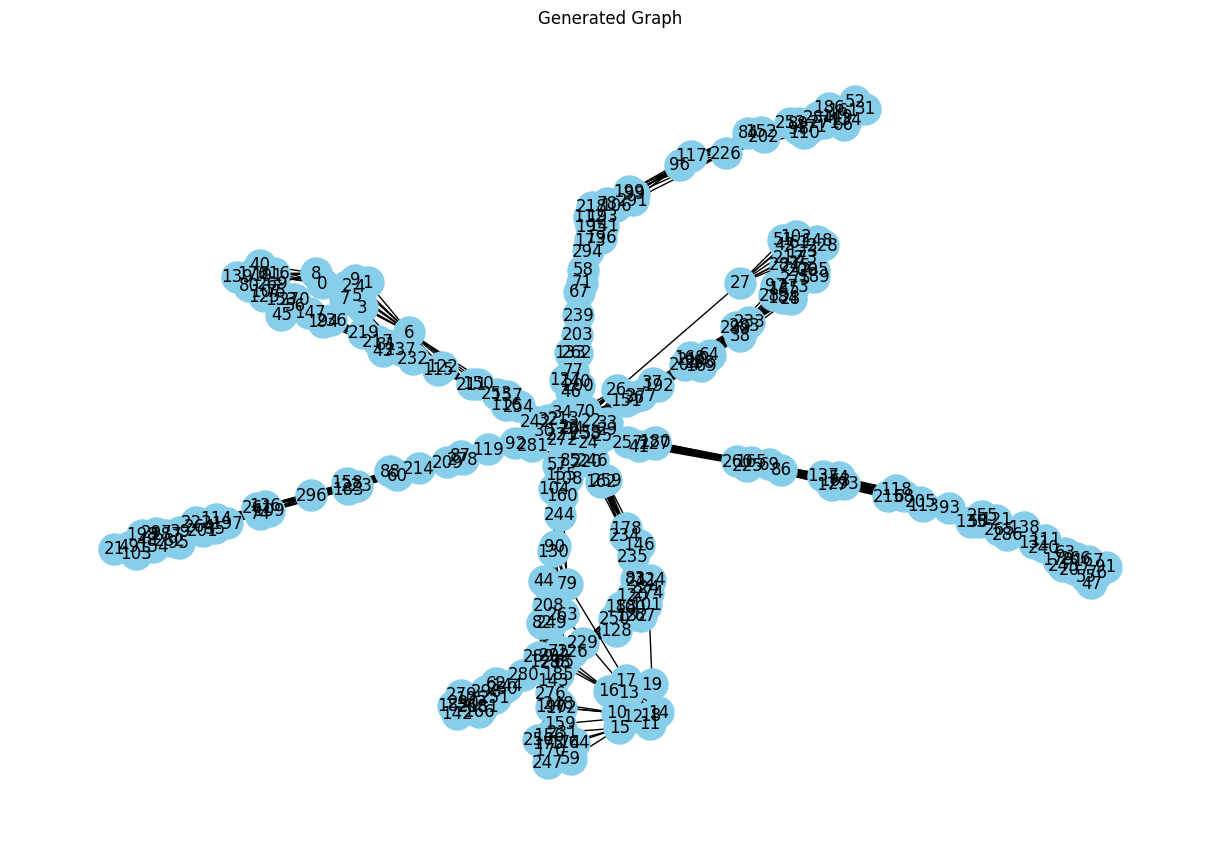

NotImplementedError: adding a nonzero scalar to a sparse matrix is not supported

In [149]:
# Generate the adjacency matrix
adjacency_matrix = dynamic_knn_adj_array
neighborhood_matrix = adjacency_matrix
# Visualize the graph
G = nx.from_numpy_array(dynamic_knn_adj_array)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=12, width=1)
plt.title("Generated Graph")
plt.show()


#compute normalised laplacian:
# This is a modified laplacian, instead of subtracting from identity matrix, we add it
def compute_normalized_laplacian(neighborhood_matrix):
    """
    Compute the normalized Laplacian matrix for a given neighborhood (adjacency) matrix.
    
    Parameters:
    - neighborhood_matrix (numpy.ndarray): The adjacency matrix of the graph.
    
    Returns:
    - numpy.ndarray: The normalized Laplacian matrix.
    
    The addition of ones on the diagonal in the normalized Laplacian provides a reference point, 
    emphasizing the difference between a node's connectivity and a hypothetical isolated state.
    - isolated states are given as the diagonal ones in the identity matrix.
    - A negative value closer to zero represents less connected values
    - A negative value further away from zero represtns more connected values
    - This essentially captures the relative lack of connectivity in relation to their neighbors 
    """
    
    # Compute degrees for each node
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1  # Adding 1 to avoid division by zero
    
    # Calculate the inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    
    
    # Create the diagonal matrix of inverse square root degrees
    #inv_sqrt_deg_matrix = np.diag(inv_sqrt_degrees)
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    
    # Compute the normalized adjacency matrix
    normalized_adjacency = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    
    # Compute the normalized Laplacian matrix
    normalized_laplacian = scipy.sparse.eye(neighborhood_matrix.shape[0]) + normalized_adjacency
    
    return normalized_laplacian

# Example usage:
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
normalized_laplacian = np.array(compute_normalized_laplacian(neighborhood_matrix))
normalized_laplacian = normalized_laplacian+(1*e**-6)
normalized_laplacian = normalized_laplacian/normalized_laplacian.sum(axis=1)[:,None]
#normalized_laplacian = normalized_laplacian/normalized_laplacian.sum(axis=0)

# This is a invrt sqrt_norm mat
def compute_inv_sqrt_norm(neighborhood_matrix):
    """
    Compute the inverted normalised square root matrix for a given neighborhood (adjacency) matrix.
    
    Parameters:
    - neighborhood_matrix (numpy.ndarray): The adjacency matrix of the graph.
    
    Returns:
    - numpy.ndarray: The normalized Laplacian matrix.
    
    The addition of ones on the diagonal in the normalized Laplacian provides a reference point, 
    emphasizing the difference between a node's connectivity and a hypothetical isolated state.
    - isolated states are given as the diagonal ones in the identity matrix.
    - A negative value closer to zero represents less connected values
    - A negative value further away from zero represtns more connected values
    - This essentially captures the relative lack of connectivity in relation to their neighbors 
    """
    
    # Compute degrees for each node
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1  # Adding 1 to avoid division by zero
    
    # Calculate the inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    
    
    # Create the diagonal matrix of inverse square root degrees
    #inv_sqrt_deg_matrix = np.diag(inv_sqrt_degrees)
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    
    # Compute the normalized adjacency matrix
    normalized_adjacency = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    
    return normalized_adjacency

# Example usage:
# Assuming 'neighborhood_matrix' is defined elsewhere in your code
normalized_inv = compute_inv_sqrt_norm(neighborhood_matrix)
normalized_inv = normalized_inv+(1*e**-6)
normalized_inv = normalized_inv/normalized_inv.sum(axis=1)[:,None]
# normalized_inv = normalized_inv/normalized_inv.sum(axis=0)

normalized_adj = neighborhood_matrix+(1*e**-6)
normalized_adj = normalized_adj/normalized_adj.sum(axis=1)[:,None]
# normalized_adj = normalized_adj/normalized_adj.sum(axis=0)

def pagerank(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    Calculate the PageRank of each node in a graph.
    
    Parameters:
    M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    num_iterations (int): The maximum number of iterations to perform.
    d (float): The damping factor.
    tolerance (float): The tolerance for convergence.
    
    Returns:
    numpy.ndarray: The PageRank score for each node in the graph.
    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    damping = ((1 - d) / N) * np.ones((N, 1))
    last_v = np.ones((N, 1)) * np.inf
    l2_dic = {}
    for _ in range(num_iterations):
        last_v = v
        v = d * M @ v + damping
        l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(_))
            break
            
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()))
    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.grid(True)
    plt.show()

    return v, l2_dic

def plot_graph_with_scores(G, scores, title):
    """
    Plot the graph with nodes colored by the given scores.
    
    Parameters:
    - G (networkx.Graph): The graph.
    - scores (dictionary of numpy.ndarray): The scores for coloring nodes.
    - title (str): The title for the plot.
    """
    
    
    pos = nx.spring_layout(G)
    for score in scores.keys():
        print(score)
        scores_ = scores[score]
        title_ = str(title) + str(score) 
        plt.figure(figsize=(12, 8))
        nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=scores_, cmap=plt.cm.coolwarm)
        nx.draw_networkx_edges(G, pos, width=1)
        nx.draw_networkx_labels(G, pos, font_size=10)
        plt.title(title_)
        plt.colorbar(nodes)
        plt.axis('off')
        plt.show()
    return pos
        

print('PG on norm adj')
normalized_adj_pg,l2_dic  = pagerank(normalized_adj, 1000, d=0.5, tolerance=1e-20)
print('PG on norm inv sqrt degree')
normalized_inv_pg,l2_dic = pagerank(normalized_inv, 1000, d=0.5, tolerance=1e-20)
print('PG on norm laplacian')
normalized_laplacian_pg,l2_dic = pagerank(normalized_laplacian, 1000, d=0.5, tolerance=1e-20)

scores = {
'normalized_adj_pg':normalized_adj_pg,
'normalized_inv_pg':normalized_inv_pg,
'normalized_laplacian_pg':normalized_laplacian_pg,
}

# Plot the graph colored by PageRank scores for the normalized adjacency matrix
pos = plot_graph_with_scores(G, scores, "PageRank -")

In [111]:
# look at local density, then use a gasussian to assign low-weights to neighbors far away. 
# threshold n_neighbors based on these weights

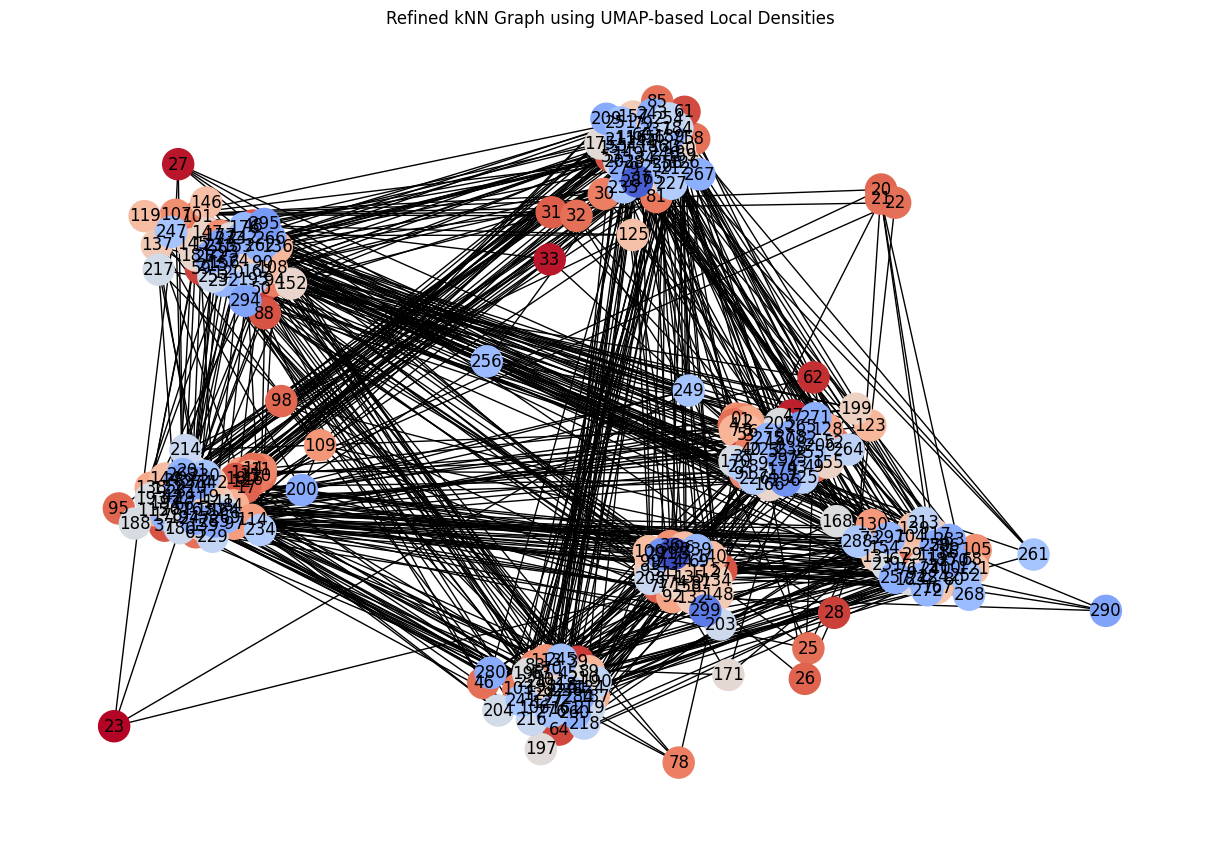

/tmp/ipykernel_1991/1617005201.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=normalized_laplacian_pg.min(), vmax=normalized_laplacian_pg.max())))


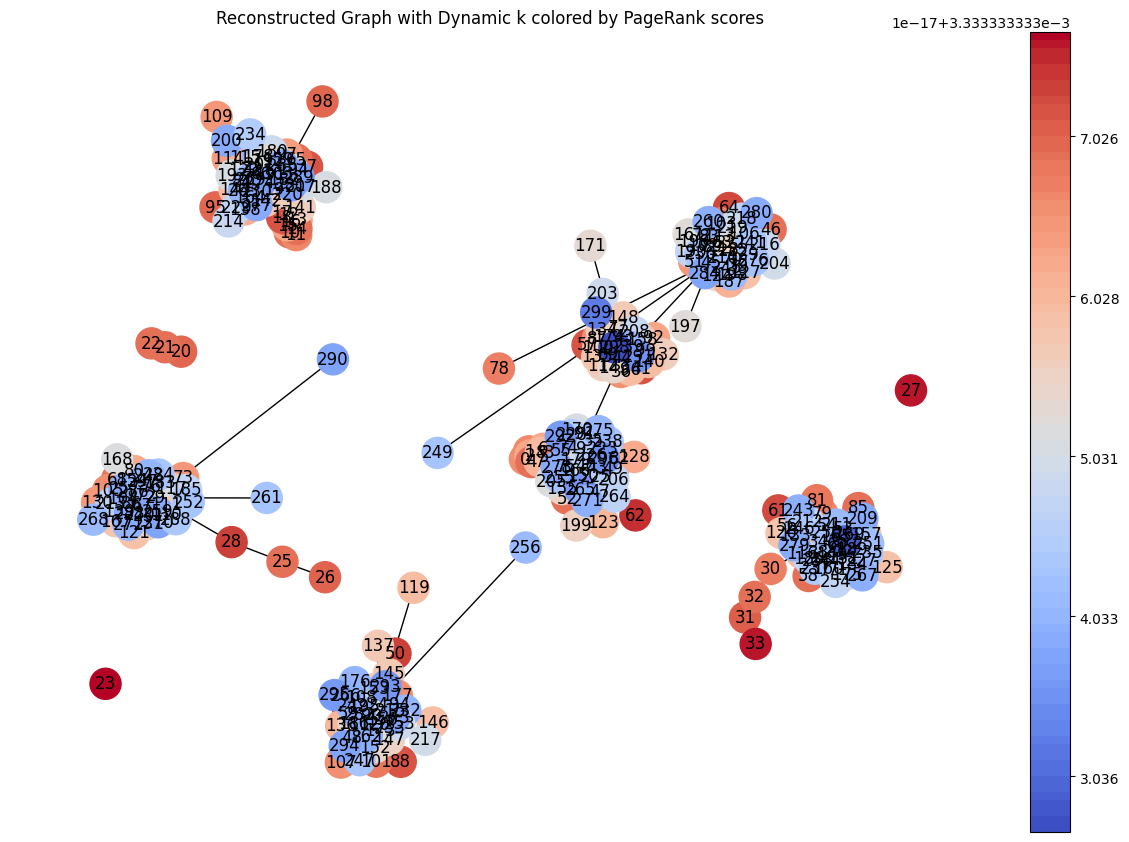

In [134]:
import numpy as np
import umap
from scipy.sparse import lil_matrix
import networkx as nx
import matplotlib.pyplot as plt


def compute_local_density_umap(adjacency_matrix, k=10):
    """Compute local density for each node using UMAP."""
    # Use UMAP to find k-nearest neighbors
    umap_model = umap.UMAP(n_neighbors=k, metric='euclidean').fit(adjacency_matrix)
    
    # Extract distances and indices from UMAP's graph
    distances = umap_model.graph_.toarray()
    indices = distances.argsort()
    
    # Get k smallest distances for each node & mean distances
    avg_distances = np.array([row[np.nonzero(row)[0][:k]].mean() for row in distances])
    return avg_distances


def dynamic_k_based_on_density(density, max_k, min_k):
    """Map normalized density values to a dynamic k."""
    normalized_density = (density - density.min()) / (density.max() - density.min())
    return min_k + (max_k - min_k) * normalized_density

def refined_dynamic_knn(adjacency_matrix, max_k, min_k):
    """Construct the kNN graph using dynamic k values based on local density."""
    n_nodes = adjacency_matrix.shape[0]
    
    # Compute local densities
    local_densities = compute_local_density_umap(adjacency_matrix, k=max_k)
    
    # Map local densities to dynamic k values
    k_values = dynamic_k_based_on_density(local_densities, max_k, min_k).astype(int)
    
    # Initialize a new adjacency matrix
    new_adj_matrix = lil_matrix(adjacency_matrix.shape)
    
    # Use UMAP's NNDescent for approximate nearest neighbor search
    index = NNDescent(adjacency_matrix)
    
    # Get the k nearest neighbors for all nodes
    neighbors = index.query(adjacency_matrix, k=max_k)[0]
    
    # For each node, only keep the top k neighbors
    for i in range(n_nodes):
        new_adj_matrix[i, neighbors[i][:k_values[i]]] = 1
    
    # Convert the LIL matrix to CSR format for efficiency
    new_adj_matrix = new_adj_matrix.tocsr()
    
    return new_adj_matrix


# Generate the adjacency matrix (you can use the `generate_simulated_adjacency_matrix` function)
adjacency_matrix = generate_simulated_adjacency_matrix()

# Set parameters for the refined kNN computation
min_k = 5
max_k = 20

# Compute the refined dynamic kNN graph using UMAP-based local densities
refined_knn_adj_matrix = refined_dynamic_knn(adjacency_matrix, min_k, max_k)

# Convert the sparse CSR matrix to a dense numpy array for visualization
refined_knn_adj_array = refined_knn_adj_matrix.toarray()
refined_knn_adj_array = refined_knn_adj_array - scipy.sparse.eye(refined_knn_adj_array.shape[0])
# Visualize the graph
G_refined_knn = nx.from_numpy_array(refined_knn_adj_array)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_refined_knn)
nx.draw(G_refined_knn, pos, with_labels=True, node_size=500, node_color=normalized_laplacian_pg.flatten(), cmap=plt.cm.coolwarm, font_size=12, width=1)
plt.title("Refined kNN Graph using UMAP-based Local Densities")
plt.show()


pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
# Using the PageRank scores for coloring
nx.draw(G_orig_knn, pos, with_labels=True, node_size=500, node_color=normalized_laplacian_pg.flatten(), cmap=plt.cm.coolwarm, font_size=12, width=1)
plt.title("Reconstructed Graph with Dynamic k colored by PageRank scores")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=normalized_laplacian_pg.min(), vmax=normalized_laplacian_pg.max())))
plt.show()

In [131]:
import pandas as pd
pd.DataFrame(adjacency_matrix[23])

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
295,0.0
296,0.0
297,0.0
298,0.0


In [109]:
import numpy as np
import umap
from scipy.sparse import lil_matrix
import networkx as nx
import matplotlib.pyplot as pl

def compute_local_density_umap(data, k=10):
    """Compute local density for each node using UMAP."""
    umap_model = umap.UMAP(n_neighbors=k, metric='euclidean').fit(data)
    distances = umap_model.graph_.toarray()
    indices = distances.argsort()
    k_distances = np.array([row[row.nonzero()][:k] for row in distances])
    avg_distances = k_distances.mean(axis=1)
    return avg_distances

def dynamic_knn_refinement(data=None, precomputed_knn=None, min_k=5):
    """Refine kNN graph based on local graph structures."""
    
    if precomputed_knn is not None:
        max_k = precomputed_knn.max()
        adjacency_matrix = precomputed_knn
    else:
        umap_model = umap.UMAP(n_neighbors=min_k, metric='euclidean').fit(data)
        adjacency_matrix = umap_model.graph_.toarray()
        max_k = min_k
    
    local_densities = compute_local_density_umap(data, k=max_k)
    n_nodes = len(local_densities)
    
    # Rank nodes based on local densities
    ranks = np.argsort(local_densities)[::-1]
    k_values = np.linspace(max_k, min_k, n_nodes).astype(int)
    k_values = k_values[np.argsort(ranks)]
    
    new_adj_matrix = lil_matrix(adjacency_matrix.shape)
    neighbors = adjacency_matrix.argsort()[:, -max_k:]
    
    for i in range(n_nodes):
        new_adj_matrix[i, neighbors[i, -k_values[i]:]] = 1
        
    return new_adj_matrix.tocsr()



# Assume 'pc_matrix' is your matrix of 50 PCs
# If you have a precomputed kNN, pass it as 'precomputed_knn', otherwise, pass None
precomputed_knn = None  # or your precomputed matrix
min_k = 5

refined_knn_adj_matrix = dynamic_knn_refinement(data=None, precomputed_knn=precomputed_knn, min_k=min_k)

# Convert the sparse CSR matrix to a dense numpy array for visualization
refined_knn_adj_array = refined_knn_adj_matrix.toarray()

# Visualize the graph
G_refined_knn = nx.from_numpy_array(refined_knn_adj_array)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_refined_knn)
nx.draw(G_refined_knn, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=12, width=1)
plt.title("Refined kNN Graph using UMAP-based Local Densities")
plt.show()


ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [70]:
normalized_adj[0][0:10]

array([0.00037884, 0.05494919, 0.14819508, 0.15233487, 0.00294639,
       0.13972481, 0.12452096, 0.06978434, 0.14151606, 0.05578638])

In [71]:
normalized_adjacency[0][0:10]

array([0.00150096, 0.0394337 , 0.08911893, 0.10993289, 0.0030712 ,
       0.08294119, 0.07282547, 0.05173923, 0.09561688, 0.01854123])

In [11]:
1/(np.sqrt(neighborhood_matrix.sum(axis=1)))

/tmp/ipykernel_1991/3596378748.py:1: RuntimeWarning: divide by zero encountered in true_divide
  1/(np.sqrt(neighborhood_matrix.sum(axis=1)))


array([ 0.41524847,  0.51448208,  0.42368381,  0.53194556,  0.43969164,
        0.41670976,  0.40845565,  0.54182153,  0.4884283 ,  0.2066863 ,
        0.56620483,  0.40880021,  0.51002368,  0.45234141,  0.4416211 ,
        0.46198585,  0.44756377,  0.47278694,  0.40091582,  0.19914646,
       25.2452151 ,  0.81656474,  1.14463602,  1.04846684,  0.22431171,
        1.16570929,  1.9759151 ,  1.10949986,  0.79261109,  0.2267851 ,
               inf,  0.80455937,  1.25806426,         inf,  0.22845158,
        2.94951974,  1.07085728,  1.45913985,  1.44448473,  1.21526807,
        1.23422035,  1.01601615,  2.45359985,  1.60879829,  0.24971898,
        0.20909785,  1.55102692,  1.7239597 ,  1.36298397,  1.05514625,
        1.35629307,  1.0722764 ,  2.03088576,  1.16329336,  3.24999936,
        1.11618545,  2.0290557 ,  1.94497802,  1.07843084,  1.8125706 ,
        1.06720122, 11.0314644 ,  2.28546795,  1.15546962,  1.07022412,
        2.61412006,  9.47102795,  1.29618807,  1.19164568,  1.38

In [9]:
normalized_inv.sum(axis = 1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., nan,  1.,  1., nan,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

# Simple video, no slowing and no pause

Converged at iteration 146


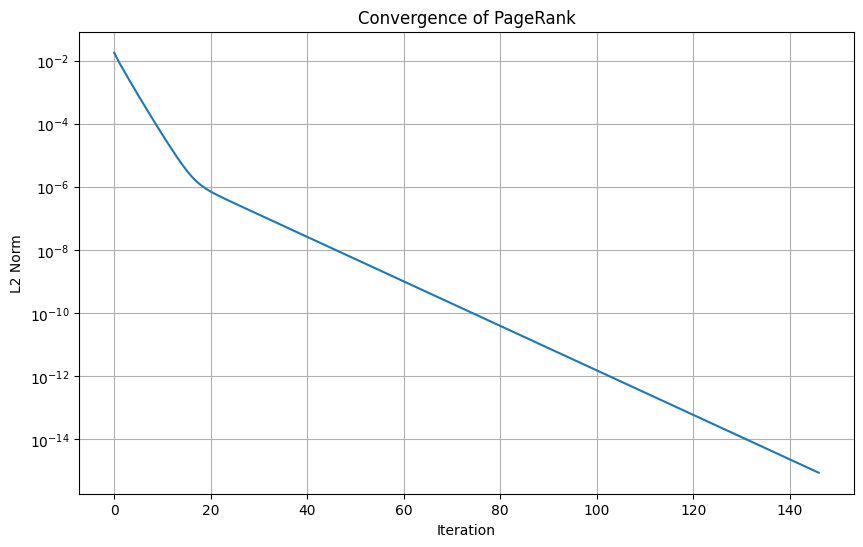

Moviepy - Building video pagerank_progression.mp4.
Moviepy - Writing video pagerank_progression.mp4



Moviepy - Done !
Moviepy - video ready pagerank_progression.mp4


In [2]:
import random

import matplotlib.animation as animation
def modified_pagerank_function(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    Calculate the PageRank of each node in a graph.
    
    Parameters:
    M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    num_iterations (int): The maximum number of iterations to perform.
    d (float): The damping factor.
    tolerance (float): The tolerance for convergence.
    
    Returns:
    numpy.ndarray: The PageRank score for each node in the graph.
    list: List of scores at each iteration.
    dict: Convergence metrics.
    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    damping = ((1 - d) / N) * np.ones((N, 1))
    last_v = np.ones((N, 1)) * np.inf
    l2_dic = {}
    
    # Initialize list to store scores over iterations
    scores_over_iterations = []

    for _ in range(num_iterations):
        last_v = v
        v = d * M @ v + damping
        
        # Append the current scores to the list
        scores_over_iterations.append(v.flatten())
        
        l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(_))
            break
            
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()))
    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.grid(True)
    plt.show()

    return v, scores_over_iterations, l2_dic

def simulate_random_walk(M, start_node, steps=10):
    """
    Simulate a random walk on a graph represented by the transition matrix M.

    Parameters:
    - M (numpy.ndarray): The transition matrix of the graph.
    - start_node (int): The starting node for the random walk.
    - steps (int): The number of steps to simulate.
    
    Returns:
    - list: The list of nodes visited during the random walk.
    """
    
    current_node = start_node
    walk = [current_node]
    
    for _ in range(steps):
        next_nodes = M[current_node, :]
        current_node = np.random.choice(np.arange(0, M.shape[1]), p=next_nodes)
        walk.append(current_node)
    
    return walk

from moviepy.editor import VideoClip
from moviepy.editor import VideoClip, concatenate_videoclips

from moviepy.editor import VideoClip

def animate_pagerank_iterations(G, M, scores_over_iterations, title, duration=5):
    """
    Generate an animation visualizing the progression of PageRank scores over iterations
    and the simulated random walk.
    
    Parameters:
    - G (networkx.Graph): The graph.
    - M (numpy.ndarray): The transition matrix of the graph.
    - scores_over_iterations (list of numpy.ndarray): List of scores at each iteration.
    - title (str): The title for the animation.
    - duration (int): Duration of the video in seconds.
    
    Returns:
    - VideoClip: A moviepy VideoClip object showing the animation.
    """
    
    pos = nx.spring_layout(G)
    num_iterations = len(scores_over_iterations)
    frames_per_iteration = duration * 24 // num_iterations  # Assuming 24 fps
    
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(12, 8))
        frame_num = int(t*24)  # Assuming 24 fps
        iteration_num = frame_num // frames_per_iteration
        scores_ = scores_over_iterations[min(iteration_num, num_iterations-1)]
        
        nx.draw_networkx_nodes(G, pos, node_size=100, node_color=scores_, cmap=plt.cm.coolwarm, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)
        
        # Simulate the random walk
        walk_length = 10
        walk = simulate_random_walk(M, random.choice(range(M.shape[0])), walk_length)
        for i, node in enumerate(walk):
            node_pos = pos[node]
            ax.scatter(*node_pos, s=200, c='green', alpha=(1)/walk_length)  # Gradually increase alpha
        
        ax.set_title(title + f" - Iteration {iteration_num}")
        plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), ax=ax)
        plt.axis('off')
        
        # Convert Figure to RGB array
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        return image

    clip = VideoClip(make_frame, duration=duration)
    return clip

v, scores_over_iterations, l2_dic = modified_pagerank_function(normalized_laplacian, num_iterations=1000, d=0.85, tolerance=1e-15)
# Generate the animation video
clip = animate_pagerank_iterations(G, normalized_laplacian, scores_over_iterations, "PageRank Progression on Normalized Adjacency Matrix",duration=20)
clip.write_videofile("pagerank_progression.mp4", fps=24)

### Features to add
from base64 import b64encode
from IPython.display import HTML

def play(filename):
    html = ''
    video = open(filename, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)
play('pagerank_progression.mp4')

# predict next interpolated point and pause at end

In [ ]:
def animate_pagerank_iterations(G, M, scores_over_iterations, title, total_duration=5, pause_duration=3):
    """
    Generate an animation visualizing the progression of PageRank scores over iterations.
    
    Parameters:
    - G (networkx.Graph): The graph.
    - M (numpy.ndarray): The transition matrix of the graph.
    - scores_over_iterations (list of numpy.ndarray): List of scores at each iteration.
    - title (str): The title for the animation.
    - total_duration (int): Total duration of the video in seconds, excluding pause.
    - pause_duration (int): Duration of the pause at the final iteration in seconds.
    
    Returns:
    - VideoClip: A moviepy VideoClip object showing the animation.
    """
    
    pos = nx.spring_layout(G)
    num_iterations = len(scores_over_iterations)
    frames_per_iteration = (total_duration * 24) // num_iterations  # Assuming 24 fps
    
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(12, 8))
        frame_num = int(t*24)  # Assuming 24 fps
        iteration_num = frame_num // frames_per_iteration
        
        # Limit the iteration_num to the number of scores available
        iteration_num = min(iteration_num, num_iterations-1)
        
        scores_ = scores_over_iterations[iteration_num]
        
        nx.draw_networkx_nodes(G, pos, node_size=100, node_color=scores_, cmap=plt.cm.coolwarm, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)
        
        # Transition with dark green dots
        walk_length = 4
        walk = simulate_random_walk(M, random.choice(range(M.shape[0])), walk_length)
        alphas = np.linspace(0.4, 0.7, len(walk))  # Dynamically generate alphas based on walk length
        for i, node in enumerate(walk):
            node_pos = pos[node]
            ax.scatter(*node_pos, s=200, c='darkgreen', alpha=alphas[i])
        
        ax.set_title(title + f" - Iteration {iteration_num+1}")
        plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), ax=ax)
        plt.axis('off')
        
        # Convert Figure to RGB array
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        return image

    clip = VideoClip(make_frame, duration=total_duration)
    
    # Pause on the final frame for pause_duration seconds
    final_clip = VideoClip(lambda x: make_frame(total_duration-0.04), duration=pause_duration)
    final_clip = concatenate_videoclips([clip, final_clip])
    
    return final_clip

# Generate the animation video
clip = animate_pagerank_iterations(G, normalized_laplacian, scores_over_iterations, "PageRank Progression on Normalized Adjacency Matrix", total_duration=7)
clip.write_videofile("pagerank_progression.mp4", fps=24)

play('pagerank_progression.mp4')

# Add the linegraph

In [3]:
def animate_pagerank_iterations(G, M, scores_over_iterations, l2_norms, title, total_duration=5, pause_duration=3):
    """
    Generate an animation visualizing the progression of PageRank scores over iterations and the L2_norm.
    
    Parameters:
    - G (networkx.Graph): The graph.
    - M (numpy.ndarray): The transition matrix of the graph.
    - scores_over_iterations (list of numpy.ndarray): List of scores at each iteration.
    - l2_norms (list of float): L2_norm values for each iteration.
    - title (str): The title for the animation.
    - total_duration (int): Total duration of the video in seconds, excluding pause.
    - pause_duration (int): Duration of the pause at the final iteration in seconds.
    
    Returns:
    - VideoClip: A moviepy VideoClip object showing the animation.
    """
    pos = nx.spring_layout(G)
    num_iterations = len(scores_over_iterations)
    frames_per_iteration = (total_duration * 24) // num_iterations  # Assuming 24 fps
    def make_frame(t):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
        # Plot the graph on the top subplot
        frame_num = int(t*24)  # Assuming 24 fps
        iteration_num = frame_num // frames_per_iteration
        iteration_num = min(iteration_num, num_iterations-1)
        scores_ = scores_over_iterations[iteration_num]
        nx.draw_networkx_nodes(G, pos, node_size=100, node_color=scores_, cmap=plt.cm.coolwarm, ax=ax1)
        nx.draw_networkx_edges(G, pos, width=1, ax=ax1)
        nx.draw_networkx_labels(G, pos, font_size=12, ax=ax1)
        
        # Transition with dark green dots
        walk_length = 4
        if iteration_num == num_iterations - 1:
            walk = []
        else:
            walk = simulate_random_walk(M, random.choice(range(M.shape[0])), walk_length)
        alphas = np.linspace(0.4, 0.7, len(walk))
        for i, node in enumerate(walk):
            node_pos = pos[node]
            ax1.scatter(*node_pos, s=200, c='darkgreen', alpha=alphas[i])
        ax1.set_title(title + f" - Iteration {iteration_num+1}")
        ax1.axis('off')
        # Plot L2_norm values on the bottom subplot
        ax2.plot(l2_norms[:iteration_num+1], 'b-', marker='o')
        ax2.set_yscale("log")
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('L2 Norm')
        ax2.grid(True)
        ax2.set_xlim(0, num_iterations)
        ax2.set_ylim(min(l2_norms)*0.5, max(l2_norms)*1.5)
        # Convert Figure to RGB array
        fig.tight_layout()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return image
    clip = VideoClip(make_frame, duration=total_duration)
    
    # Pause on the final frame for pause_duration seconds
    final_clip = VideoClip(lambda x: make_frame(total_duration-0.04), duration=pause_duration)
    final_clip = concatenate_videoclips([clip, final_clip])
    return final_clip

#_, scores_over_iterations, l2_dic = pagerank(normalized_laplacian, num_iterations=100, d=0.85, tolerance=1e-6)
l2_norms = list(l2_dic.values())
clip = animate_pagerank_iterations(G, normalized_laplacian, scores_over_iterations, l2_norms, "PageRank Progression on Normalized Adjacency Matrix", total_duration=22)
clip.write_videofile("pagerank_progression.mp4", fps=24)

play('pagerank_progression.mp4')

Moviepy - Building video pagerank_progression.mp4.
Moviepy - Writing video pagerank_progression.mp4



Moviepy - Done !
Moviepy - video ready pagerank_progression.mp4


# Empirical bayes sampler

In [ ]:
scores = {
'normalized_adj_pg':normalized_adj_pg,
'normalized_inv_pg':normalized_inv_pg,
'normalized_laplacian_pg':normalized_laplacian_pg,
}

# Sampled data